In [64]:
import os, time
import warnings
import numpy as np
from functools import wraps, reduce
from scipy.special import expit, softmax

import tensorflow as tf
import tensorflow.keras.backend as K

from keras_applications.imagenet_utils import _obtain_input_shape 

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import get_source_inputs, get_file
from tensorflow.keras.layers import (Input, ZeroPadding2D, Conv2D, DepthwiseConv2D, ReLU, LeakyReLU, UpSampling2D,
                                    Concatenate)
from tensorflow.keras.optimizers.schedules import ExponentialDecay, PolynomialDecay, PiecewiseConstantDecay
from tensorflow.keras.callbacks import (TensorBoard, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler,
                                       EarlyStopping, TerminateOnNaN, Callback)

L2_FACTOR = 1e-5

BASE_WEIGHT_PATH = ('https://github.com/fchollet/deep-learning-models/'
                    'releases/download/v0.6/')

In [2]:
# Try to enable Auto Mixed Precision on TF 2.0
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'
os.environ['TF_AUTO_MIXED_PRECISION_GRAPH_REWRITE_IGNORE_PERFORMANCE'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
tf.__version__.startswith('2')

True

In [5]:
gpus = tf.config.experimental.list_physical_devices('XLA_GPU')

In [6]:
gpus

[PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU')]

In [7]:
annotation_file = "trainval.txt"
log_dir = os.path.join('logs', '000')
classes_path = "configs/bird_pics_classes.txt"
with open(classes_path) as f:
    class_names = f.readlines()
class_names = [c.strip() for c in class_names]
num_classes = len(class_names)
class_names

['Cacatua galerita',
 'Ara chloroptera',
 'Psittacus erithacus',
 'Ara ararauna',
 'Cacatua goffiniana']

In [8]:
anchors_path = "configs/yolo3_anchors.txt"
with open(anchors_path) as f:
    anchors = f.readline()
anchors = [float(x) for x in anchors.split(',')]
anchors = np.array(anchors).reshape(-1, 2)
num_anchors = len(anchors)
anchors

array([[ 10.,  13.],
       [ 16.,  30.],
       [ 33.,  23.],
       [ 30.,  61.],
       [ 62.,  45.],
       [ 59., 119.],
       [116.,  90.],
       [156., 198.],
       [373., 326.]])

In [9]:
freeze_level = 1

In [10]:
print(log_dir)
logging = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=False, write_grads=False, write_images=False, update_freq='batch')
checkpoint = ModelCheckpoint(os.path.join(log_dir, 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'),
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
    save_freq=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=10, verbose=1, cooldown=0, min_lr=1e-10)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='min')
terminate_on_nan = TerminateOnNaN()
callbacks=[logging, checkpoint, reduce_lr, early_stopping, terminate_on_nan]

logs/000


In [11]:
with open(annotation_file) as f:
    lines = f.readlines()
    lines = [line.strip() for line in lines]

np.random.seed(int(time.time()))
np.random.shuffle(lines)

dataset = lines
dataset

['./bird_pics/train/Ara_chloroptera/-1870_a.jpg 38,42,209,187,1 140,65,177,105,1',
 './bird_pics/validation/Ara_ararauna/validation_112.jpg 5,10,576,400,3',
 './bird_pics/train/Cacatua_galerita/-951_a.jpg 71,16,188,199,0',
 './bird_pics/validation/Cacatua_galerita/-29_b.jpg 68,75,107,156,0',
 './bird_pics/validation/Ara_chloroptera/336.jpg 245,5,1199,720,1',
 './bird_pics/train/Cacatua_goffiniana/1100.jpg 290,1,603,507,4',
 './bird_pics/validation/Ara_ararauna/validation_284.jpg 242,55,485,400,3',
 './bird_pics/train/Ara_chloroptera/-1570_a.jpg 1,16,178,224,1',
 './bird_pics/validation/Cacatua_goffiniana/-565_a.jpg 1,1,185,223,4',
 './bird_pics/train/Ara_chloroptera/-1540_a.jpg 73,34,192,109,1 56,109,176,201,1',
 './bird_pics/train/Ara_chloroptera/1303f0826637645506c730d4b2192873.jpg 29,49,224,224,1',
 './bird_pics/train/Cacatua_goffiniana/-2959_a.jpg 25,9,224,224,4',
 './bird_pics/validation/Cacatua_goffiniana/-577_a.jpg 89,72,222,224,4',
 './bird_pics/train/Cacatua_galerita/58d50832a

In [12]:
val_split = 0.1
num_val = int(len(dataset)*val_split)
num_train = len(dataset) - num_val
print(num_train, num_val)

5868 652


In [13]:
rescale_interval = -1

In [14]:
input_shape = (416, 416)
assert (input_shape[0]%32 == 0 and input_shape[1]%32 == 0), 'model_image_size should be multiples of 32'

In [15]:
#get_train_model = get_yolo3_train_model
#data_generator = yolo3_data_generator_wrapper
tiny_version = False

In [16]:
def compose(*funcs):
    """Compose arbitrarily many functions, evaluated left to right.
    Reference: https://mathieularose.com/function-composition-in-python/
    """
    # return lambda x: reduce(lambda v, f: f(v), funcs, x)
    if funcs:
        return reduce(lambda f, g: lambda *a, **kw: g(f(*a, **kw)), funcs)
    else:
        raise ValueError('Composition of empty sequence not supported.')

In [20]:
@wraps(Conv2D)
def YoloConv2D(*args, **kwargs):
    """Wrapper to set Yolo parameters for Conv2D."""
    yolo_conv_kwargs = {'kernel_regularizer': l2(L2_FACTOR)}
    yolo_conv_kwargs['bias_regularizer'] = l2(L2_FACTOR)
    yolo_conv_kwargs.update(kwargs)
    #yolo_conv_kwargs = kwargs
    return Conv2D(*args, **yolo_conv_kwargs)


@wraps(DepthwiseConv2D)
def YoloDepthwiseConv2D(*args, **kwargs):
    """Wrapper to set Yolo parameters for DepthwiseConv2D."""
    yolo_conv_kwargs = {'kernel_regularizer': l2(L2_FACTOR)}
    yolo_conv_kwargs['bias_regularizer'] = l2(L2_FACTOR)
    yolo_conv_kwargs.update(kwargs)
    #yolo_conv_kwargs = kwargs
    return DepthwiseConv2D(*args, **yolo_conv_kwargs)


@wraps(YoloConv2D)
def DarknetConv2D(*args, **kwargs):
    """Wrapper to set Darknet parameters for YoloConv2D."""
    #darknet_conv_kwargs = {'kernel_regularizer': l2(5e-4)}
    #darknet_conv_kwargs['padding'] = 'valid' if kwargs.get('strides')==(2,2) else 'same'
    darknet_conv_kwargs = {'padding': 'valid' if kwargs.get('strides')==(2,2) else 'same'}
    darknet_conv_kwargs.update(kwargs)
    return YoloConv2D(*args, **darknet_conv_kwargs)


def DarknetConv2D_BN_Leaky(*args, **kwargs):
    """Darknet Convolution2D followed by CustomBatchNormalization and LeakyReLU."""
    no_bias_kwargs = {'use_bias': False}
    no_bias_kwargs.update(kwargs)
    return compose(
        DarknetConv2D(*args, **no_bias_kwargs),
        CustomBatchNormalization(),
        LeakyReLU(alpha=0.1))


def Depthwise_Separable_Conv2D_BN_Leaky(filters, kernel_size=(3, 3), block_id_str=None):
    """Depthwise Separable Convolution2D."""
    if not block_id_str:
        block_id_str = str(K.get_uid())
    return compose(
        YoloDepthwiseConv2D(kernel_size, padding='same', name='conv_dw_' + block_id_str),
        CustomBatchNormalization(name='conv_dw_%s_bn' % block_id_str),
        LeakyReLU(alpha=0.1, name='conv_dw_%s_leaky_relu' % block_id_str),
        YoloConv2D(filters, (1,1), padding='same', use_bias=False, strides=(1, 1), name='conv_pw_%s' % block_id_str),
        CustomBatchNormalization(name='conv_pw_%s_bn' % block_id_str),
        LeakyReLU(alpha=0.1, name='conv_pw_%s_leaky_relu' % block_id_str))



def CustomBatchNormalization(*args, **kwargs):
    if tf.__version__ >= '2.2':
        from tensorflow.keras.layers.experimental import SyncBatchNormalization
        BatchNorm = SyncBatchNormalization
    return BatchNorm(*args, **kwargs)


def _conv_block(inputs, filters, alpha, kernel=(3, 3), strides=(1, 1)):
    """Adds an initial convolution layer (with batch normalization and relu6).
    # Arguments
        inputs: Input tensor of shape `(rows, cols, 3)`
            (with `channels_last` data format) or
            (3, rows, cols) (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 32.
            E.g. `(224, 224, 3)` would be one valid value.
        filters: Integer, the dimensionality of the output space
            (i.e. the number of output filters in the convolution).
        alpha: controls the width of the network.
            - If `alpha` < 1.0, proportionally decreases the number
                of filters in each layer.
            - If `alpha` > 1.0, proportionally increases the number
                of filters in each layer.
            - If `alpha` = 1, default number of filters from the paper
                 are used at each layer.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
            Can be a single integer to specify the same value for
            all spatial dimensions.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution
            along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
            Specifying any stride value != 1 is incompatible with specifying
            any `dilation_rate` value != 1.
    # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if data_format='channels_first'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if data_format='channels_last'.
    # Output shape
        4D tensor with shape:
        `(samples, filters, new_rows, new_cols)`
        if data_format='channels_first'
        or 4D tensor with shape:
        `(samples, new_rows, new_cols, filters)`
        if data_format='channels_last'.
        `rows` and `cols` values might have changed due to stride.
    # Returns
        Output tensor of block.
    """
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    filters = int(filters * alpha)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)), name='conv1_pad')(inputs)
    x = YoloConv2D(filters, kernel,
                      padding='valid',
                      use_bias=False,
                      strides=strides,
                      name='conv1')(x)
    x = CustomBatchNormalization(axis=channel_axis, name='conv1_bn')(x)
    return ReLU(6., name='conv1_relu')(x)


def _depthwise_conv_block(inputs, pointwise_conv_filters, alpha,
                          depth_multiplier=1, strides=(1, 1), block_id=1):
    """Adds a depthwise convolution block.
    A depthwise convolution block consists of a depthwise conv,
    batch normalization, relu6, pointwise convolution,
    batch normalization and relu6 activation.
    # Arguments
        inputs: Input tensor of shape `(rows, cols, channels)`
            (with `channels_last` data format) or
            (channels, rows, cols) (with `channels_first` data format).
        pointwise_conv_filters: Integer, the dimensionality of the output space
            (i.e. the number of output filters in the pointwise convolution).
        alpha: controls the width of the network.
            - If `alpha` < 1.0, proportionally decreases the number
                of filters in each layer.
            - If `alpha` > 1.0, proportionally increases the number
                of filters in each layer.
            - If `alpha` = 1, default number of filters from the paper
                 are used at each layer.
        depth_multiplier: The number of depthwise convolution output channels
            for each input channel.
            The total number of depthwise convolution output
            channels will be equal to `filters_in * depth_multiplier`.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution
            along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
            Specifying any stride value != 1 is incompatible with specifying
            any `dilation_rate` value != 1.
        block_id: Integer, a unique identification designating
            the block number.
    # Input shape
        4D tensor with shape:
        `(batch, channels, rows, cols)` if data_format='channels_first'
        or 4D tensor with shape:
        `(batch, rows, cols, channels)` if data_format='channels_last'.
    # Output shape
        4D tensor with shape:
        `(batch, filters, new_rows, new_cols)`
        if data_format='channels_first'
        or 4D tensor with shape:
        `(batch, new_rows, new_cols, filters)`
        if data_format='channels_last'.
        `rows` and `cols` values might have changed due to stride.
    # Returns
        Output tensor of block.
    """
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    pointwise_conv_filters = int(pointwise_conv_filters * alpha)

    if strides == (1, 1):
        x = inputs
    else:
        x = ZeroPadding2D(((0, 1), (0, 1)),
                                 name='conv_pad_%d' % block_id)(inputs)
    x = YoloDepthwiseConv2D((3, 3),
                               padding='same' if strides == (1, 1) else 'valid',
                               depth_multiplier=depth_multiplier,
                               strides=strides,
                               use_bias=False,
                               name='conv_dw_%d' % block_id)(x)
    x = CustomBatchNormalization(
        axis=channel_axis, name='conv_dw_%d_bn' % block_id)(x)
    x = ReLU(6., name='conv_dw_%d_relu' % block_id)(x)

    x = YoloConv2D(pointwise_conv_filters, (1, 1),
                      padding='same',
                      use_bias=False,
                      strides=(1, 1),
                      name='conv_pw_%d' % block_id)(x)
    x = CustomBatchNormalization(axis=channel_axis,
                                  name='conv_pw_%d_bn' % block_id)(x)
    return ReLU(6., name='conv_pw_%d_relu' % block_id)(x)


def make_depthwise_separable_last_layers(x, num_filters, out_filters, block_id_str=None, predict_filters=None, predict_id='1'):
    '''6 Conv2D_BN_Leaky layers followed by a Conv2D_linear layer'''
    if not block_id_str:
        block_id_str = str(K.get_uid())
    x = compose(
            DarknetConv2D_BN_Leaky(num_filters, (1,1)),
            Depthwise_Separable_Conv2D_BN_Leaky(filters=num_filters*2, kernel_size=(3, 3), block_id_str=block_id_str+'_1'),
            DarknetConv2D_BN_Leaky(num_filters, (1,1)),
            Depthwise_Separable_Conv2D_BN_Leaky(filters=num_filters*2, kernel_size=(3, 3), block_id_str=block_id_str+'_2'),
            DarknetConv2D_BN_Leaky(num_filters, (1,1)))(x)

    if predict_filters is None:
        predict_filters = num_filters*2
    y = compose(
            Depthwise_Separable_Conv2D_BN_Leaky(filters=predict_filters, kernel_size=(3, 3), block_id_str=block_id_str+'_3'),
            DarknetConv2D(out_filters, (1,1), name='predict_conv_' + predict_id))(x)
    return x, y

In [21]:
#mobilenet = MobileNet(input_tensor=inputs, weights='imagenet', include_top=False, alpha=alpha)
input_tensor=Input(shape=(None, None, 3), name="image_input")
input_shape=None
weights="imagenet"
include_top=False
alpha=1.0
depth_multiplier=1
dropout=1e-3
pooling=None
classes=1000

"""
_obtain_input_shape(input_shape,
                        default_size,
                        min_size,
                        data_format,
                        require_flatten,
                        weights=None):
    "Internal utility to compute/validate a model's input shape.
    # Arguments
        input_shape: Either None (will return the default network input shape),
            or a user-provided shape to be validated.
        default_size: Default input width/height for the model.
        min_size: Minimum input width/height accepted by the model.
        data_format: Image data format to use.
        require_flatten: Whether the model is expected to
            be linked to a classifier via a Flatten layer.
        weights: One of `None` (random initialization)
            or 'imagenet' (pre-training on ImageNet).
            If weights='imagenet' input channels must be equal to 3.
    # Returns
        An integer shape tuple (may include None entries).
    # Raises
        ValueError: In case of invalid argument values.
    "
                        
"""

# Determine proper input shape and default size.
if input_shape is None:
    default_size = 224
        
input_shape = _obtain_input_shape(input_shape,
                                 default_size=default_size,
                                 min_size=32,
                                 data_format=K.image_data_format(),
                                 require_flatten=include_top,
                                 weights=weights)

if K.image_data_format() == 'channels_last':
    row_axis, col_axis = (0, 1)
    
rows = input_shape[row_axis] #None
cols = input_shape[col_axis] #None

if weights == 'imagenet':
    if rows != cols or rows not in [128, 160, 192, 224]:
        rows = 224
        warnings.warn('`input_shape` is undefined or non-square, '
                      'or `rows` is not in [128, 160, 192, 224]. '
                      'Weights for input shape (224, 224) will be'
                      ' loaded as the default.')
        
if input_tensor is None:
        img_input = Input(shape=input_shape)
else:
    #if not K.is_keras_tensor(input_tensor):
        #img_input = Input(tensor=input_tensor, shape=input_shape)
    #else:
        #img_input = input_tensor
    img_input = input_tensor
    

x = _conv_block(img_input, 32, alpha, strides=(2, 2))
x = _conv_block(img_input, 32, alpha, strides=(2, 2))
x = _depthwise_conv_block(x, 64, alpha, depth_multiplier, block_id=1)

x = _depthwise_conv_block(x, 128, alpha, depth_multiplier,
                          strides=(2, 2), block_id=2)
x = _depthwise_conv_block(x, 128, alpha, depth_multiplier, block_id=3)

x = _depthwise_conv_block(x, 256, alpha, depth_multiplier,
                          strides=(2, 2), block_id=4)
x = _depthwise_conv_block(x, 256, alpha, depth_multiplier, block_id=5)

x = _depthwise_conv_block(x, 512, alpha, depth_multiplier,
                          strides=(2, 2), block_id=6)
x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=7)
x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=8)
x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=9)
x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=10)
x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=11)

x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier,
                          strides=(2, 2), block_id=12)
x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier, block_id=13)

"""
tf.keras.utils.get_source_inputs(
    tensor, layer=None, node_index=None
)
Returns the list of input tensors necessary to compute tensor
Output will always be a list of tensors (potentially with 1 element).
Arguments
-tensor: The tensor to start from.
-layer: Origin layer of the tensor. Will be determined via tensor._keras_history if not provided.
-node_index: Origin node index of the tensor.
Returns
-List of input tensors.
"""
if input_tensor is not None:
    inputs = get_source_inputs(input_tensor)
    
model = Model(inputs, x, name='mobilenet_%0.2f_%s' % (alpha, rows))


"""
tf.keras.utils.get_file(
    fname, origin, untar=False, md5_hash=None, file_hash=None,
    cache_subdir='datasets', hash_algorithm='auto',
    extract=False, archive_format='auto', cache_dir=None
)
Downloads a file from a URL if it not already in the cache.
Arguments
-fname: Name of the file. If an absolute path /path/to/file.txt is specified the file will be saved at that location.
-origin: Original URL of the file.
-cache_subdir: Subdirectory under the Keras cache dir where the file is saved. If an absolute path /path/to/folder is specified the file will be saved at that location.
"""


# Load weights.
if weights == 'imagenet':
    if alpha == 1.0:
        alpha_text = '1_0'
    if include_top:
        model_name = 'mobilenet_%s_%d_tf.h5' % (alpha_text, rows)
        weight_path = BASE_WEIGHT_PATH + model_name
        weights_path = get_file(model_name,
                                weight_path,
                                cache_subdir='models')
    else:
        model_name = 'mobilenet_%s_%d_tf_no_top.h5' % (alpha_text, rows)
        weight_path = BASE_WEIGHT_PATH + model_name
        weights_path = get_file(model_name,
                                weight_path,
                                cache_subdir='models')
        
    model.load_weights(weights_path)
    
mobilenet = model
print('backbone layers number: {}'.format(len(mobilenet.layers)))
# f1: 13 x 13 x (1024*alpha)
f1 = mobilenet.get_layer('conv_pw_13_relu').output
# f2: 26 x 26 x (512*alpha)
f2 = mobilenet.get_layer('conv_pw_11_relu').output
# f3: 52 x 52 x (256*alpha)
f3 = mobilenet.get_layer('conv_pw_5_relu').output

f1_channel_num = int(1024*alpha)
f2_channel_num = int(512*alpha)
f3_channel_num = int(256*alpha)

feature_maps = (f1, f2, f3)
feature_channel_nums = (f1_channel_num, f2_channel_num, f3_channel_num)
num_anchors = num_anchors
num_classes = num_classes
use_spp = False

x, y1 = make_depthwise_separable_last_layers(f1, f1_channel_num//2, num_anchors * (num_classes + 5), block_id_str='pred_1', predict_id='1')

x = compose(
    DarknetConv2D_BN_Leaky(f2_channel_num//2, (1,1)),
    UpSampling2D(2))(x)
x = Concatenate()([x,f2])

x, y2 = make_depthwise_separable_last_layers(x, f2_channel_num//2, num_anchors * (num_classes + 5), block_id_str='pred_2', predict_id='2')

x = compose(
    DarknetConv2D_BN_Leaky(f3_channel_num//2, (1,1)),
    UpSampling2D(2))(x)
x = Concatenate()([x, f3])

x, y3 = make_depthwise_separable_last_layers(x, f3_channel_num//2, num_anchors * (num_classes + 5), block_id_str='pred_3', predict_id='3')

model_body = Model(inputs = inputs, outputs=[y1,y2,y3])

<ipython-input-21-7bc8e65f2eb7>:59: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


backbone layers number: 87


In [22]:
model_body.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           image_input[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 3 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (SyncBatchNormalizatio (None, None, None, 3 128         conv1[0][0]                      
_______________________________________________________________________________________

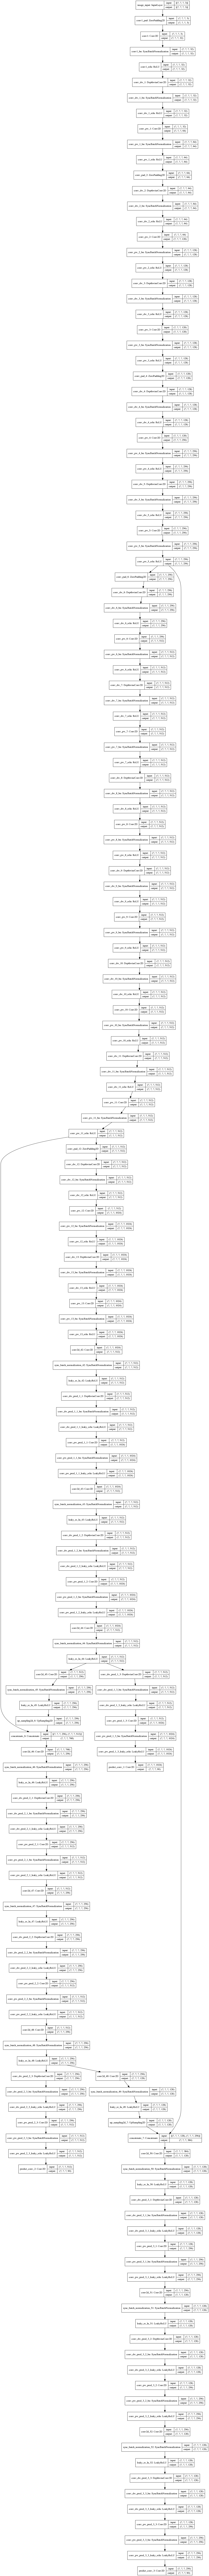

In [98]:
tf.keras.utils.plot_model(model_body, show_shapes=True)

In [23]:
model_body, backbone_len = model_body, 87
num_feature_layers = num_anchors//3
model_type="yolo3_mobilenet_lite"
print('Create {} {} model with {} anchors and {} classes.'.format('Tiny' if num_feature_layers==2 else '', model_type, num_anchors, num_classes))
print('model layer number:', len(model_body.layers))

Create  yolo3_mobilenet_lite model with 9 anchors and 5 classes.
model layer number: 181


In [24]:
if freeze_level in [1, 2]:
    # Freeze the backbone part or freeze all but final feature map & input layers.
    num = (backbone_len, len(model_body.layers)-3)[freeze_level-1]
    for i in range(num): model_body.layers[i].trainable = False
    print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

Freeze the first 87 layers of total 181 layers.


In [25]:
#feature map target value, so its shape should be like:
# [
#  (image_height/32, image_width/32, 3, num_classes+5),
#  (image_height/16, image_width/16, 3, num_classes+5),
#  (image_height/8, image_width/8, 3, num_classes+5)
# ]
y_true = [Input(shape=(None, None, 3, num_classes+5), name='y_true_{}'.format(l)) for l in range(num_feature_layers)]
y_true

[<tf.Tensor 'y_true_0:0' shape=(None, None, None, 3, 10) dtype=float32>,
 <tf.Tensor 'y_true_1:0' shape=(None, None, None, 3, 10) dtype=float32>,
 <tf.Tensor 'y_true_2:0' shape=(None, None, None, 3, 10) dtype=float32>]

In [32]:
args = [*model_body.output, *y_true]
anchors= anchors; num_classes= num_classes; ignore_thresh = 0.5; label_smoothing=0
elim_grid_sense=False; num_layers = len(anchors)//3; yolo_outputs = args[:num_layers]
y_true = args[num_layers:]

print(yolo_outputs)
print()
print(y_true)

[<tf.Tensor 'predict_conv_1/BiasAdd:0' shape=(None, None, None, 90) dtype=float32>, <tf.Tensor 'predict_conv_2/BiasAdd:0' shape=(None, None, None, 90) dtype=float32>, <tf.Tensor 'predict_conv_3/BiasAdd:0' shape=(None, None, None, 90) dtype=float32>]

[<tf.Tensor 'y_true_0:0' shape=(None, None, None, 3, 10) dtype=float32>, <tf.Tensor 'y_true_1:0' shape=(None, None, None, 3, 10) dtype=float32>, <tf.Tensor 'y_true_2:0' shape=(None, None, None, 3, 10) dtype=float32>]


In [34]:
if num_layers == 3:
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]]
    scale_x_y = [1.05, 1.1, 1.2] if elim_grid_sense else [None, None, None]
    
print(scale_x_y)

[None, None, None]


In [35]:
K.shape()

<tf.Tensor 'strided_slice:0' shape=(2,) dtype=int32>

In [36]:
yolo_outputs[0]

<tf.Tensor 'predict_conv_1/BiasAdd:0' shape=(None, None, None, 90) dtype=float32>

In [51]:
input_shape = K.cast(K.shape(yolo_outputs[0])[1:3] * 32, K.dtype(y_true[0]))
input_shape

<tf.Tensor 'Cast_1:0' shape=(2,) dtype=float32>

In [52]:
grid_shapes = [K.cast(K.shape(yolo_outputs[i])[1:3], K.dtype(y_true[0])) for i in range(num_layers)]
grid_shapes

[<tf.Tensor 'Cast_2:0' shape=(2,) dtype=float32>,
 <tf.Tensor 'Cast_3:0' shape=(2,) dtype=float32>,
 <tf.Tensor 'Cast_4:0' shape=(2,) dtype=float32>]

In [53]:
loss = 0
total_location_loss = 0
total_confidence_loss = 0
total_class_loss = 0

In [54]:
batch_size = K.shape(yolo_outputs[0])[0]
batch_size

<tf.Tensor 'strided_slice_14:0' shape=() dtype=int32>

In [55]:
batch_size_f = K.cast(batch_size, K.dtype(yolo_outputs[0]))
batch_size_f

<tf.Tensor 'Cast_5:0' shape=() dtype=float32>

In [68]:
def yolo3_decode(feats, anchors, num_classes, input_shape, scale_x_y=None, calc_loss=False):
    """Decode final layer features to bounding box parameters."""
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.constant(anchors), [1, 1, 1, num_anchors, 2])

    grid_shape = K.shape(feats)[1:3] # height, width
    grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
        [1, grid_shape[1], 1, 1])
    grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
        [grid_shape[0], 1, 1, 1])
    grid = K.concatenate([grid_x, grid_y])
    grid = K.cast(grid, K.dtype(feats))

    feats = K.reshape(
        feats, [-1, grid_shape[0], grid_shape[1], num_anchors, num_classes + 5])

    # Adjust preditions to each spatial grid point and anchor size.
    if scale_x_y:
        # Eliminate grid sensitivity trick involved in YOLOv4
        #
        # Reference Paper & code:
        #     "YOLOv4: Optimal Speed and Accuracy of Object Detection"
        #     https://arxiv.org/abs/2004.10934
        #     https://github.com/opencv/opencv/issues/17148
        #
        box_xy_tmp = K.sigmoid(feats[..., :2]) * scale_x_y - (scale_x_y - 1) / 2
        box_xy = (box_xy_tmp + grid) / K.cast(grid_shape[..., ::-1], K.dtype(feats))
    else:
        box_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[..., ::-1], K.dtype(feats))
    box_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[..., ::-1], K.dtype(feats))
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.sigmoid(feats[..., 5:])

    if calc_loss == True:
        return grid, feats, box_xy, box_wh
    return box_xy, box_wh, box_confidence, box_class_probs

In [79]:
for i in range(num_layers):
    object_mask = y_true[i][..., 4:5]
    true_class_probs = y_true[i][..., 5:]
    if label_smoothing:
        true_class_probs = _smooth_labels(true_class_probs, label_smoothing)
        true_objectness_probs = _smooth_labels(object_mask, label_smoothing)
    else:
        true_objectness_probs = object_mask
        
    grid, raw_pred, pred_xy, pred_wh = yolo3_decode(yolo_outputs[i],
        anchors[anchor_mask[i]], num_classes, input_shape, scale_x_y=scale_x_y[i], calc_loss=True)
    
    pred_box = K.concatenate([pred_xy, pred_wh])
    
    # Darknet raw box to calculate loss.
    raw_true_xy = y_true[i][..., :2]*grid_shapes[i][::-1] - grid
    raw_true_wh = K.log(y_true[i][..., 2:4] / anchors[anchor_mask[i]] * input_shape[::-1])
    raw_true_wh = K.switch(object_mask, raw_true_wh, K.zeros_like(raw_true_wh)) # avoid log(0)=-inf
    box_loss_scale = 2 - y_true[i][...,2:3]*y_true[i][...,3:4]
    
    # Find ignore mask, iterate over each of batch.
    ignore_mask = tf.TensorArray(K.dtype(y_true[0]), size=1, dynamic_size=True)
    object_mask_bool = K.cast(object_mask, 'bool')
    def loop_body(b, ignore_mask):
        true_box = tf.boolean_mask(y_true[i][b,...,0:4], object_mask_bool[b,...,0])
        iou = box_iou(pred_box[b], true_box)
        best_iou = K.max(iou, axis=-1)
        ignore_mask = ignore_mask.write(b, K.cast(best_iou<ignore_thresh, K.dtype(true_box)))
        return b+1, ignore_mask
    _, ignore_mask = tf.while_loop(lambda b,*args: b<batch_size, loop_body, [0, ignore_mask])
    ignore_mask = ignore_mask.stack()
    ignore_mask = K.expand_dims(ignore_mask, -1)

OperatorNotAllowedInGraphError: using a `tf.Tensor` as a Python `bool` is not allowed in Graph execution. Use Eager execution or decorate this function with @tf.function.